<a href="https://colab.research.google.com/github/Trantracy/Fine_tuning_Deep_Neural_Networks/blob/master/Fine_tuning_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Deep Neural Networks

In [0]:
# Import library
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pathlib
import random
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
# Visualize model history
def plot_history(history, key='loss'):
    plt.figure(figsize=(12,8))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

## Mini-batch

In [0]:
#@title Prepare data

# Download data
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)

# Generate image paths
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

# Generate image labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# Image processing function
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# Create Dataset
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)

image_label_ds

print("Preparation completed!")

Preparation completed!


In [0]:
image_count

3670

In [0]:
# Create Model
def create_model():
  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
  mobile_net.trainable=False

  model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  
  return model

model = create_model()

### Batch Gradient Descent

In [0]:
# Batch Gradient Descent
BATCH_SIZE = image_count # All training data is used to take a step
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
history = model.fit(ds, epochs=10,steps_per_epoch=steps_per_epoch)

Epoch 1/10


### Stochastic Gradient Descent

In [0]:
# Stochastic Gradient Descent
BATCH_SIZE = 1 # A simple sample is used to take a step
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
history = model.fit(ds, epochs=1,steps_per_epoch=steps_per_epoch)

3670/3670 [==============================] - 126s 34ms/step - loss: 0.7723 - accuracy: 0.8052


### Mini-batch Gradient Descent

In [0]:
# Stochastic Gradient Descent
BATCH_SIZE = 32 # A batch of sample is used to take a step
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
history = model.fit(ds, epochs=1,steps_per_epoch=steps_per_epoch)

115/115 [==============================] - 102s 883ms/step - loss: 0.7716 - accuracy: 0.7310


## Prevent Overfitting

In [0]:
#@title Prepare Data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

FEATURES = 28

ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
  if optimizer is None:
    optimizer = get_optimizer()

  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    verbose=1)
  return history

print("Preparation Completed!")

Preparation Completed!


In [0]:
# Tiny model
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

history_tiny = compile_and_fit(tiny_model, 'sizes/Tiny')

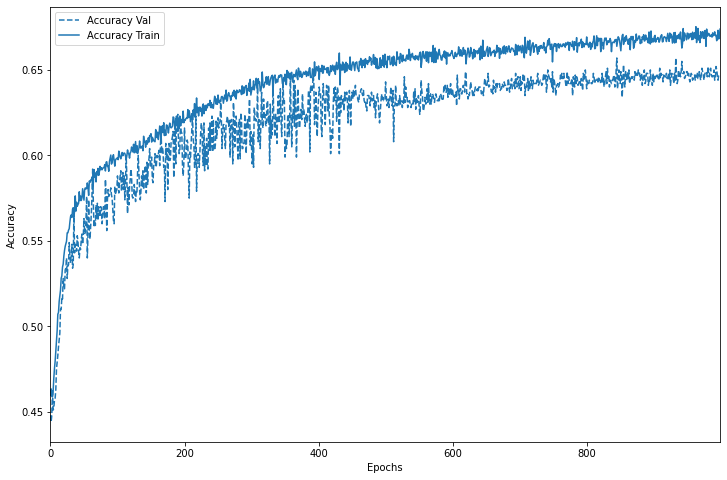

In [0]:
plot_history(history_tiny, key='accuracy')

In [0]:
# Small model
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
history_small = compile_and_fit(small_model, 'sizes/Small')


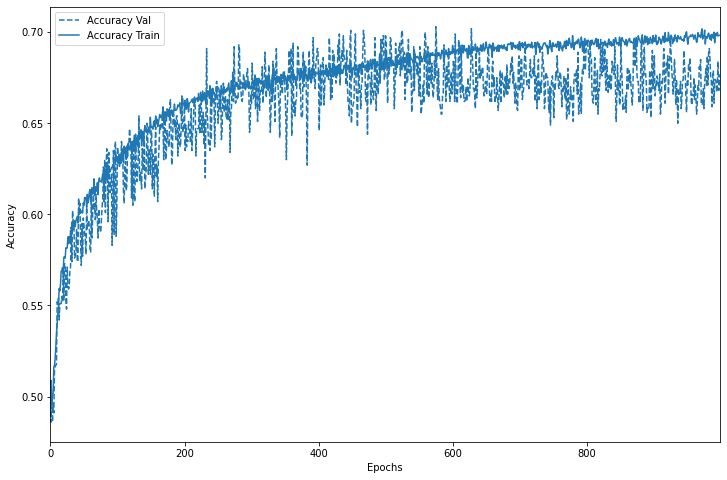

In [0]:
plot_history(history_small, key='accuracy')

In [0]:
# Medium model
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
history_medium  = compile_and_fit(medium_model, "sizes/Medium")

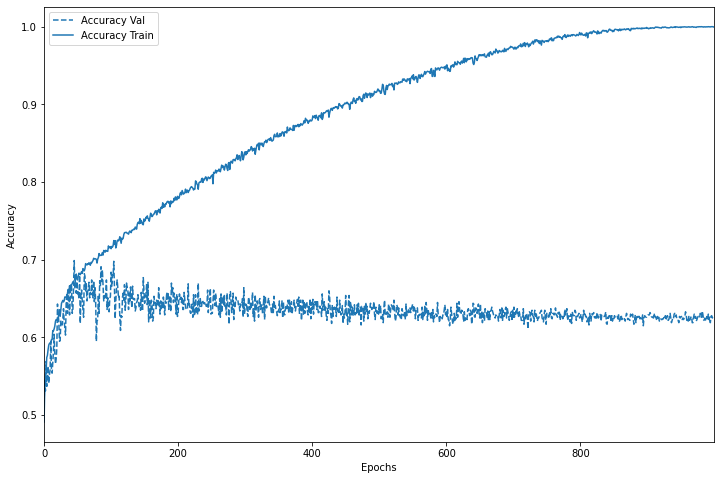

In [0]:
plot_history(history_medium, key='accuracy')

In [0]:
# Large model
    large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

history_large = compile_and_fit(medium_model, "sizes/Large")

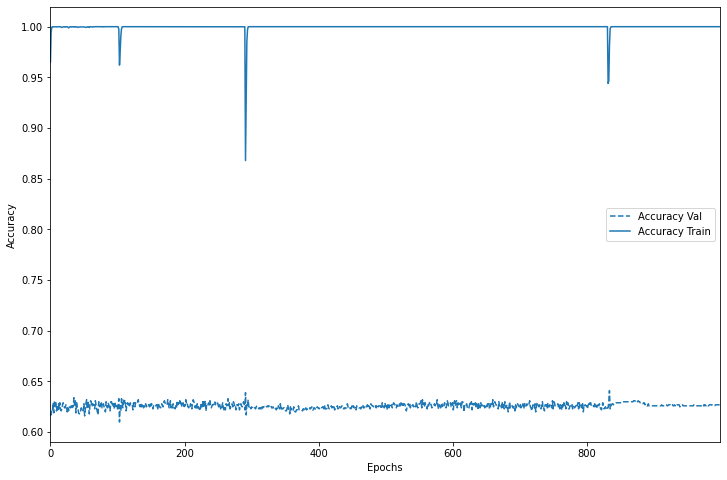

In [0]:
plot_history(history_large, key='accuracy')

### Prevent Overfitting - Early Stop

In [0]:
def compile_and_fit_earlystop(model, name, optimizer=None, max_epochs=1000):
  if optimizer is None:
    optimizer = get_optimizer()

  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1) # Create EarlyStopping Callback

  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    callbacks=[earlystop], # Add callback to training process
    validation_data=validate_ds,
    verbose=1)
  return history

In [0]:
# Large model with early stop
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

history_large = compile_and_fit_earlystop(medium_model, "sizes/Large")

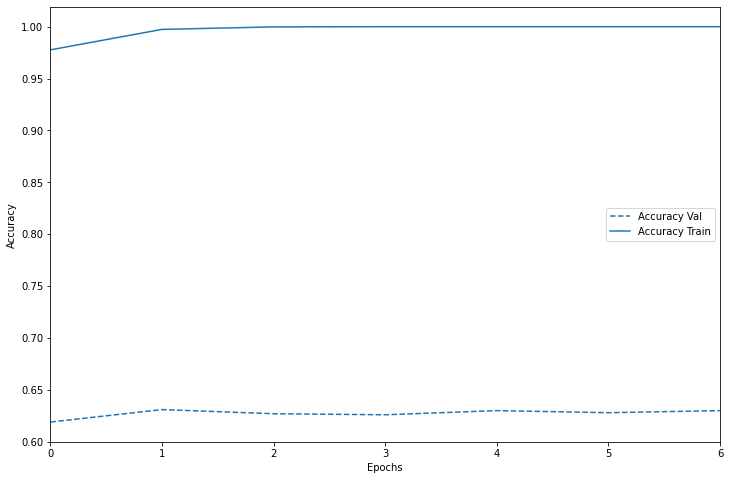

In [0]:
plot_history(history_large, key='accuracy')

### Prevent Overfitting - Weight Regularizations

In [0]:
# Large model with L2 Regularizations
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001), # L2 Regularization
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

history_large_regularized = compile_and_fit(l2_model, "regularizers/l2")

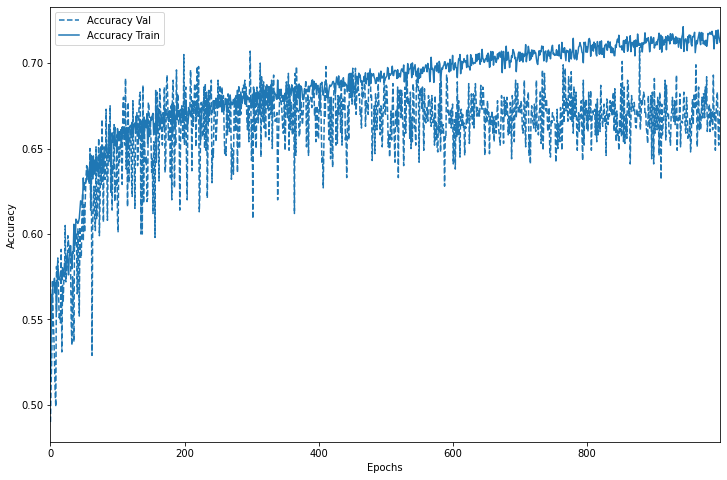

In [0]:
plot_history(history_large_regularized, key='accuracy')

### Preventing Overfit - Dropout

In [0]:
# Large model with Dropout
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5), # Dropout
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

history_large_dropout = compile_and_fit(dropout_model, "regularizers/dropout")

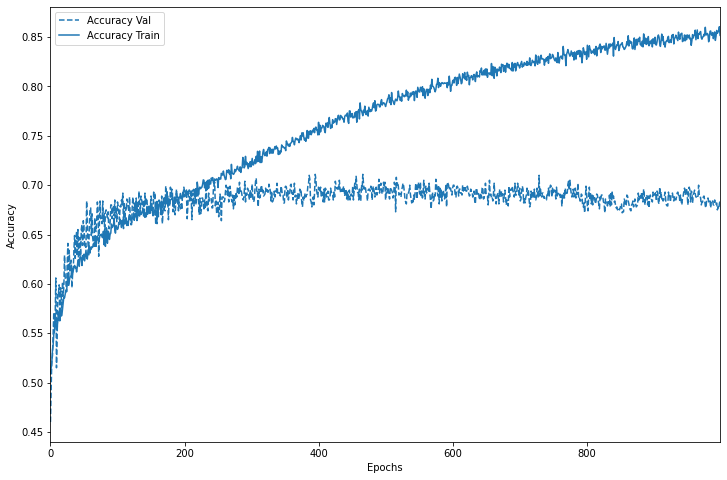

In [0]:
plot_history(history_large_dropout, key='accuracy')

In [0]:
# Large model with L2 Regularization and Dropout
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])
history_large_combined = compile_and_fit(combined_model, "regularizers/combined")

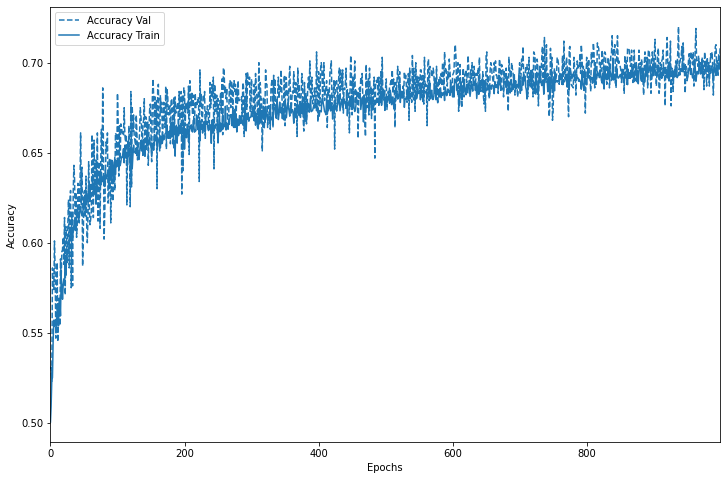

In [0]:
plot_history(history_large_combined, key='accuracy')

## Faster Optimizers

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7141 - accuracy: 0.8028 - val_loss: 0.3635 - val_accuracy: 0.9043
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3842 - accuracy: 0.8917 - val_loss: 0.2931 - val_accuracy: 0.9209
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3238 - accuracy: 0.9085 - val_loss: 0.2562 - val_accuracy: 0.9286
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2867 - accuracy: 0.9186 - val_loss: 0.2303 - val_accuracy: 0.9362
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2597 - accuracy: 0.9260 - val_loss: 0.2100 - val_accuracy: 0.9415


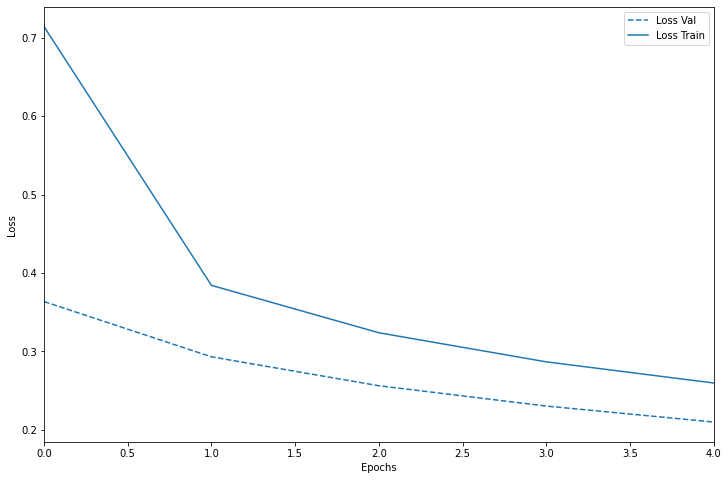

In [0]:
# SGD without momentum
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
plot_history(history, key='loss')

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3350 - accuracy: 0.9007 - val_loss: 0.1696 - val_accuracy: 0.9506
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1714 - accuracy: 0.9506 - val_loss: 0.1185 - val_accuracy: 0.9644
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1342 - accuracy: 0.9608 - val_loss: 0.0941 - val_accuracy: 0.9716
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1136 - accuracy: 0.9667 - val_loss: 0.0896 - val_accuracy: 0.9734
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976 - accuracy: 0.9710 - val_loss: 0.0820 - val_accuracy: 0.9753


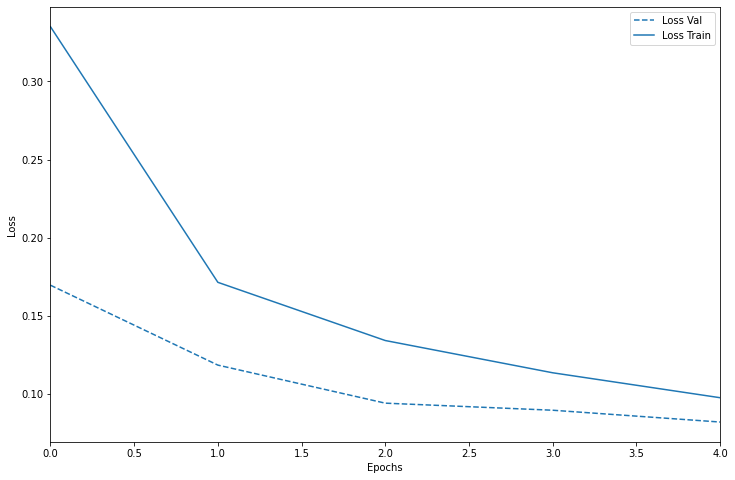

In [0]:
# SGD with momentum
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # Increase momentum to 0.9
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
plot_history(history, key='loss')

## Learning Rate Decay

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3401 - accuracy: 0.8998 - val_loss: 0.2030 - val_accuracy: 0.9397
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2579 - accuracy: 0.9286 - val_loss: 0.2055 - val_accuracy: 0.9435
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2409 - accuracy: 0.9353 - val_loss: 0.1641 - val_accuracy: 0.9562
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2197 - accuracy: 0.9424 - val_loss: 0.1891 - val_accuracy: 0.9539
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1963 - accuracy: 0.9481 - val_loss: 0.1595 - val_accuracy: 0.9611
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2000 - accuracy: 0.9478 - val_loss: 0.1654 - val_accuracy: 0.9600
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1860 - accuracy: 0.9523 - val_loss: 0.2074 - val_accuracy:

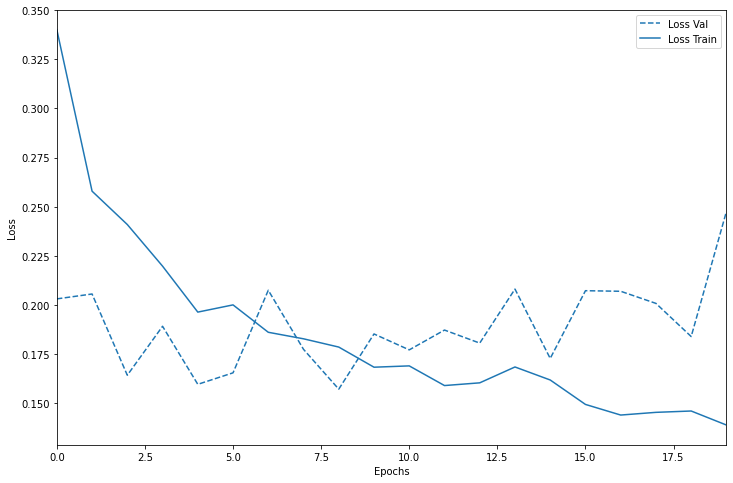

In [0]:
# Without learning rate decay
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))
plot_history(history, key='loss')

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3470 - accuracy: 0.8985 - val_loss: 0.1996 - val_accuracy: 0.9424 - lr: 0.1000
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2547 - accuracy: 0.9282 - val_loss: 0.1908 - val_accuracy: 0.9522 - lr: 0.1000
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2265 - accuracy: 0.9379 - val_loss: 0.1583 - val_accuracy: 0.9574 - lr: 0.1000
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2149 - accuracy: 0.9423 - val_loss: 0.1906 - val_accuracy: 0.9561 - lr: 0.1000
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1203 - accuracy: 0.9660 - val_loss: 0.1130 - val_accuracy: 0.9740 - lr: 0.0200
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0958 - accuracy: 0.9715 - val_loss: 0.1062 - val_accuracy: 0.9739 - lr: 0.0200
Epoch 7/20
1875/1875 [==============================] - 5s

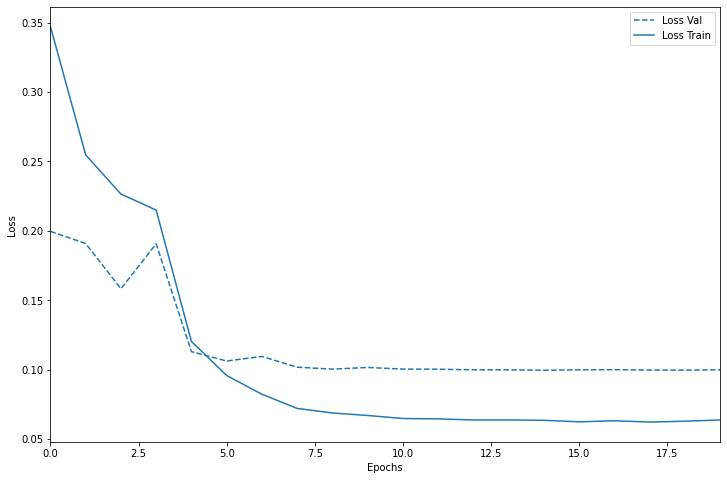

In [0]:
# With learning rate decay
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, # Create ReduceLROnPlateau Callback
                              patience=1, min_lr=0.001)

history = model.fit(X_train, y_train, epochs=20, 
                    callbacks=[reduce_lr], # Add callback to the training process
                    validation_data=(X_test, y_test))
plot_history(history, key='loss')